# Spotify Genre Classifier

## Setup

In [5]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import walk, path
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from scipy import stats
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

In [6]:
# load data

# get all filenames from the directory data
f = []
for (dirpath, dirnames, filenames) in walk("data"):
    f.extend(filenames)
    break

# load data from all files from the directory data
frames = []
for file in f:
    data = pd.read_json(path.join("data", file))
    frames.append(data)

# concat all data into one dataframe
raw_data = pd.concat(frames, ignore_index=True)

## Visualization

### Clean Dataset

In [7]:
raw_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,0.1930,0.11600,9,-25.718,1,0.0608,0.986,0.91800,0.5050,0.0836,143.301,audio_features,6pV1dGidc6DvzjKhbMqgDa,spotify:track:6pV1dGidc6DvzjKhbMqgDa,https://api.spotify.com/v1/tracks/6pV1dGidc6Dv...,https://api.spotify.com/v1/audio-analysis/6pV1...,242467,3,classic
1,0.3210,0.00611,4,-38.341,0,0.0362,0.995,0.90800,0.0900,0.0693,104.311,audio_features,1YcABWwgkfrOSw8VMgDWZU,spotify:track:1YcABWwgkfrOSw8VMgDWZU,https://api.spotify.com/v1/tracks/1YcABWwgkfrO...,https://api.spotify.com/v1/audio-analysis/1YcA...,205493,4,classic
2,0.4480,0.00520,4,-36.512,1,0.0564,0.995,0.88000,0.0698,0.0398,62.171,audio_features,1juisCcrVdwoLbDWyVvNrX,spotify:track:1juisCcrVdwoLbDWyVvNrX,https://api.spotify.com/v1/tracks/1juisCcrVdwo...,https://api.spotify.com/v1/audio-analysis/1jui...,369027,4,classic
3,0.4250,0.03630,1,-21.629,0,0.0686,0.991,0.00109,0.2500,0.7450,78.991,audio_features,1AKdBq4wtJKU9DhQpekvtc,spotify:track:1AKdBq4wtJKU9DhQpekvtc,https://api.spotify.com/v1/tracks/1AKdBq4wtJKU...,https://api.spotify.com/v1/audio-analysis/1AKd...,143777,4,classic
4,0.0748,0.04420,0,-19.183,1,0.0426,0.957,0.94000,0.1160,0.0369,79.092,audio_features,5X5x6oRSCHtHEz28ncMVd5,spotify:track:5X5x6oRSCHtHEz28ncMVd5,https://api.spotify.com/v1/tracks/5X5x6oRSCHtH...,https://api.spotify.com/v1/audio-analysis/5X5x...,348907,4,classic


In [8]:
raw_data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre'],
      dtype='object')

In [9]:
# now drop some features which have no importance for the ML task
raw_data.drop(["uri", "id", "track_href", "analysis_url", "type"], axis=1, inplace=True)

In [10]:
raw_data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'genre'],
      dtype='object')

In [11]:
raw_data.shape

(1515, 14)

In [12]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1515 non-null   float64
 1   energy            1515 non-null   float64
 2   key               1515 non-null   int64  
 3   loudness          1515 non-null   float64
 4   mode              1515 non-null   int64  
 5   speechiness       1515 non-null   float64
 6   acousticness      1515 non-null   float64
 7   instrumentalness  1515 non-null   float64
 8   liveness          1515 non-null   float64
 9   valence           1515 non-null   float64
 10  tempo             1515 non-null   float64
 11  duration_ms       1515 non-null   int64  
 12  time_signature    1515 non-null   int64  
 13  genre             1515 non-null   object 
dtypes: float64(9), int64(4), object(1)
memory usage: 165.8+ KB


In [13]:
# convert ms to sec
raw_data.duration_ms /= 1000
raw_data.rename(columns={"duration_ms": "duration_s"}, inplace=True)

In [14]:
# remove samples with key == -1
befor = len(raw_data)
raw_data = raw_data[raw_data.key != -1]
print(f"Removed samples: {befor - len(raw_data)}")

Removed samples: 0


In [15]:
len(raw_data)

1515

In [16]:
# remove samples where time_signature is out of bounds [3:7]
befor = len(raw_data)
raw_data = raw_data[(raw_data.time_signature >= 3) & (raw_data.time_signature <= 7)]
print(f"Removed samples: {befor - len(raw_data)}")

Removed samples: 19


In [17]:
raw_data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature
count,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000
mean,0.518864,0.576181,5.324866,-10.743261,0.554813,0.101637,0.359781,0.244451,0.181888,0.405590,118.611152,272.666860,3.922460
std,0.209155,0.328465,3.553143,8.596414,0.497153,0.103556,0.403647,0.369033,0.143416,0.259752,31.233030,124.525156,0.338208
min,0.061800,0.002090,0.000000,-44.526000,0.000000,0.025000,0.000002,0.000000,0.023400,0.027100,47.362000,84.267000,3.000000
25%,0.375000,0.271750,2.000000,-14.000250,0.000000,0.040475,0.010200,0.000000,0.092575,0.167000,93.895250,195.917000,4.000000
50%,0.516500,0.678000,5.000000,-7.225500,1.000000,0.052400,0.108500,0.000865,0.122000,0.387000,116.799500,237.862000,4.000000
75%,0.667000,0.864000,8.000000,-4.709500,1.000000,0.112000,0.838250,0.618250,0.234250,0.616000,145.010500,304.056750,4.000000
max,0.964000,0.998000,11.000000,-0.100000,1.000000,0.944000,0.996000,0.981000,0.972000,0.958000,206.247000,1252.322000,5.000000


In [18]:
categorical_features = {'key', 'mode', 'time_signature'}
numeric_features = set(raw_data.columns) - categorical_features - {"genre"}

numeric_features = list(numeric_features)
categorical_features = list(categorical_features)

In [29]:
x_train, x_test, y_train, y_test = train_test_split(raw_data.iloc[:,:13], raw_data.genre, test_size=0.33, stratify=raw_data.genre)
data = {
    "x_train": x_train,
    "x_test": x_test,
    "y_train": y_train,
    "y_test": y_test,
    "features": numeric_features + categorical_features,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "target": "genre"
}

In [20]:
scaler = StandardScaler()
data["x_train"][data["numeric_features"]] = scaler.fit_transform(data["x_train"][data["numeric_features"]])
data["x_train"].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature
count,1.002000e+03,1.002000e+03,1002.000000,1.002000e+03,1002.000000,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1002.000000
mean,7.562148e-17,-1.005516e-16,5.287425,-1.983333e-16,0.548902,8.199252e-18,-6.138359e-17,-3.756144e-17,-3.301861e-17,-1.517970e-16,2.298007e-16,4.347543e-16,3.920160
std,1.000499e+00,1.000499e+00,3.542411,1.000499e+00,0.497851,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,0.333918
min,-2.194548e+00,-1.751166e+00,0.000000,-3.832795e+00,0.000000,-7.504254e-01,-9.052872e-01,-6.545540e-01,-1.119669e+00,-1.486521e+00,-2.272959e+00,-1.534550e+00,3.000000
25%,-6.968559e-01,-9.008086e-01,2.000000,-3.639020e-01,0.000000,-5.985488e-01,-8.796453e-01,-6.545533e-01,-6.275091e-01,-9.304237e-01,-7.956086e-01,-6.334328e-01,4.000000
50%,7.207745e-03,3.092662e-01,5.000000,3.989676e-01,1.000000,-4.770476e-01,-5.888813e-01,-6.525843e-01,-4.034194e-01,-4.603100e-02,-4.943701e-02,-2.842764e-01,4.000000
75%,7.280348e-01,8.895538e-01,8.000000,7.050157e-01,1.000000,9.224466e-02,1.177005e+00,9.893336e-01,3.889224e-01,8.393262e-01,8.465882e-01,2.794398e-01,4.000000
max,2.124188e+00,1.282505e+00,11.000000,1.229383e+00,1.000000,4.325192e+00,1.576276e+00,1.984354e+00,5.502494e+00,2.104673e+00,2.733831e+00,7.129228e+00,5.000000


### Feature Statistic Calculations and Outlier Handling

In [21]:
iqr_factor = 1.5

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__



feature_stats = dotdict({})
feature_stats.min_wisker_value = dotdict({})
feature_stats.max_wisker_value = dotdict({})
feature_stats.std = dotdict({})
feature_stats.mean = dotdict({})

def getQuariles(feature_data):
   
    Q1 = feature_data.quantile(0.25)
    Q3 = feature_data.quantile(0.75)
    IQR = Q3 - Q1
    return Q1, Q3, IQR



def getMaxWiskerValue(feature_data) -> float:
    Q1, Q3, IQR = getQuariles(feature_data)

    wisker_value = Q3 + (IQR * iqr_factor)
    return wisker_value

def getMinWiskerValue(feature_data) -> float:
    Q1, Q3, IQR = getQuariles(feature_data)
    wisker_value = Q1 - (IQR * iqr_factor)
    return wisker_value
    


for feature_name in data["features"]:
    feature_data = data["x_train"][feature_name]
    
    feature_stats.std[feature_name] = np.std(feature_data)
    feature_stats.mean[feature_name] = np.mean(feature_data)
    feature_stats.max_wisker_value[feature_name] = getMaxWiskerValue(feature_data)
    feature_stats.min_wisker_value[feature_name] = getMinWiskerValue(feature_data)

    # set outiler to min or max wisker
    min_boundarry = feature_stats.min_wisker_value[feature_name] 
    max_boundarry = feature_stats.max_wisker_value[feature_name]
    data["x_train"][feature_name] = data["x_train"][feature_name].clip(min_boundarry, max_boundarry)


In [22]:
#outlier detection using zscore
threshold = 3
filtered_data = pd.DataFrame([])
removed_cnt = 0
train_combined = data["x_train"].copy()
train_combined["genre"] = data["y_train"]


for group_name, group_data in train_combined.groupby("genre"):
    group_data = group_data.drop("genre", 1)

    z_score = group_data.select_dtypes(include='number').apply(stats.zscore)

    filter = (abs(z_score) < threshold).all(axis=1)

    group_filtered = group_data[filter]
    group_filtered['genre'] = group_name

    removed_cnt += (group_data.shape[0] - group_filtered.shape[0])
    filtered_data = pd.concat([filtered_data, group_filtered], ignore_index=False)

print(f"Removed samples: {removed_cnt}")

data["y_train"] = filtered_data["genre"]
data["x_train"] = filtered_data.drop("genre", axis=1)

Removed samples: 1002


/var/folders/70/ck9tkfr53jz8kss1cbvrk59r0000gn/T/ipykernel_60409/1680002159.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  group_data = group_data.drop("genre", 1)


### Statistics

In [23]:
# if you want to compare statistic informations from specific features you can use: data.groupby('genre').describe()["feature1", "feature2", ...]
data["x_train"].groupby(data["y_train"]).describe()["duration_s"]

KeyError: 'duration_s'

In [ ]:
data["x_train"].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plots

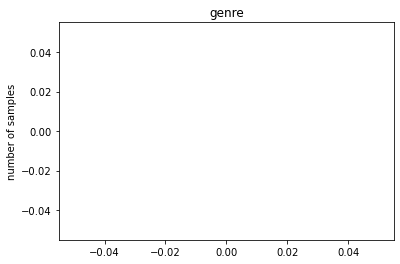

In [ ]:
sorted_list = data["y_train"].value_counts().sort_values()
labels = sorted_list.index.tolist()
values = sorted_list.tolist()

plt.bar(labels, values)
plt.title("genre")
plt.ylabel("number of samples")
plt.show()

In [ ]:
train_combined = data["x_train"].copy()
train_combined["genre"] = data["y_train"]
for feature in data["features"]:
    sns.boxplot(x="genre", y=feature, data=train_combined)
    plt.show()

ValueError: min() arg is an empty sequence

In [ ]:
data["x_train"].corr()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature
danceability,1.000000,0.491535,0.049723,0.573198,-0.099349,0.500207,-0.544577,-0.442309,0.089156,0.652367,-0.043797,-0.197162,0.286195
energy,0.491535,1.000000,0.055829,0.894582,-0.113844,0.273948,-0.919234,-0.565807,0.301513,0.437540,0.370603,-0.297934,0.309996
key,0.049723,0.055829,1.000000,0.042374,-0.171500,0.030768,-0.069555,-0.021876,0.040071,-0.032446,0.030373,0.003623,-0.007938
loudness,0.573198,0.894582,0.042374,1.000000,-0.114918,0.281113,-0.824317,-0.662657,0.291861,0.500797,0.318697,-0.274645,0.313479
mode,-0.099349,-0.113844,-0.171500,-0.114918,1.000000,0.001022,0.070142,0.067814,0.041293,-0.030150,-0.058711,0.008973,-0.035814
speechiness,0.500207,0.273948,0.030768,0.281113,0.001022,1.000000,-0.358447,-0.324298,0.156328,0.349463,-0.069407,-0.166151,0.117367
acousticness,-0.544577,-0.919234,-0.069555,-0.824317,0.070142,-0.358447,1.000000,0.585378,-0.295636,-0.405908,-0.331588,0.331908,-0.294930
instrumentalness,-0.442309,-0.565807,-0.021876,-0.662657,0.067814,-0.324298,0.585378,1.000000,-0.252247,-0.476718,-0.187069,0.303848,-0.234910
liveness,0.089156,0.301513,0.040071,0.291861,0.041293,0.156328,-0.295636,-0.252247,1.000000,0.108154,0.106123,-0.148539,0.095636
valence,0.652367,0.437540,-0.032446,0.500797,-0.030150,0.349463,-0.405908,-0.476718,0.108154,1.000000,0.003158,-0.129180,0.243309


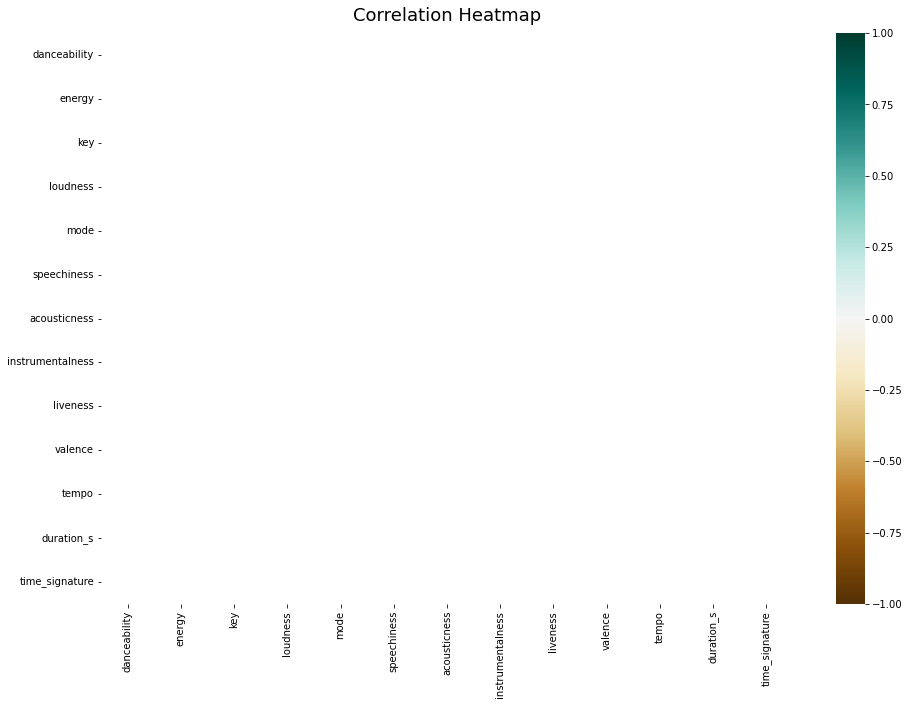

In [ ]:
fig = plt.figure()
heatmap = sns.heatmap(data["x_train"].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
fig.set_size_inches(15.5, 10.5, forward=True)

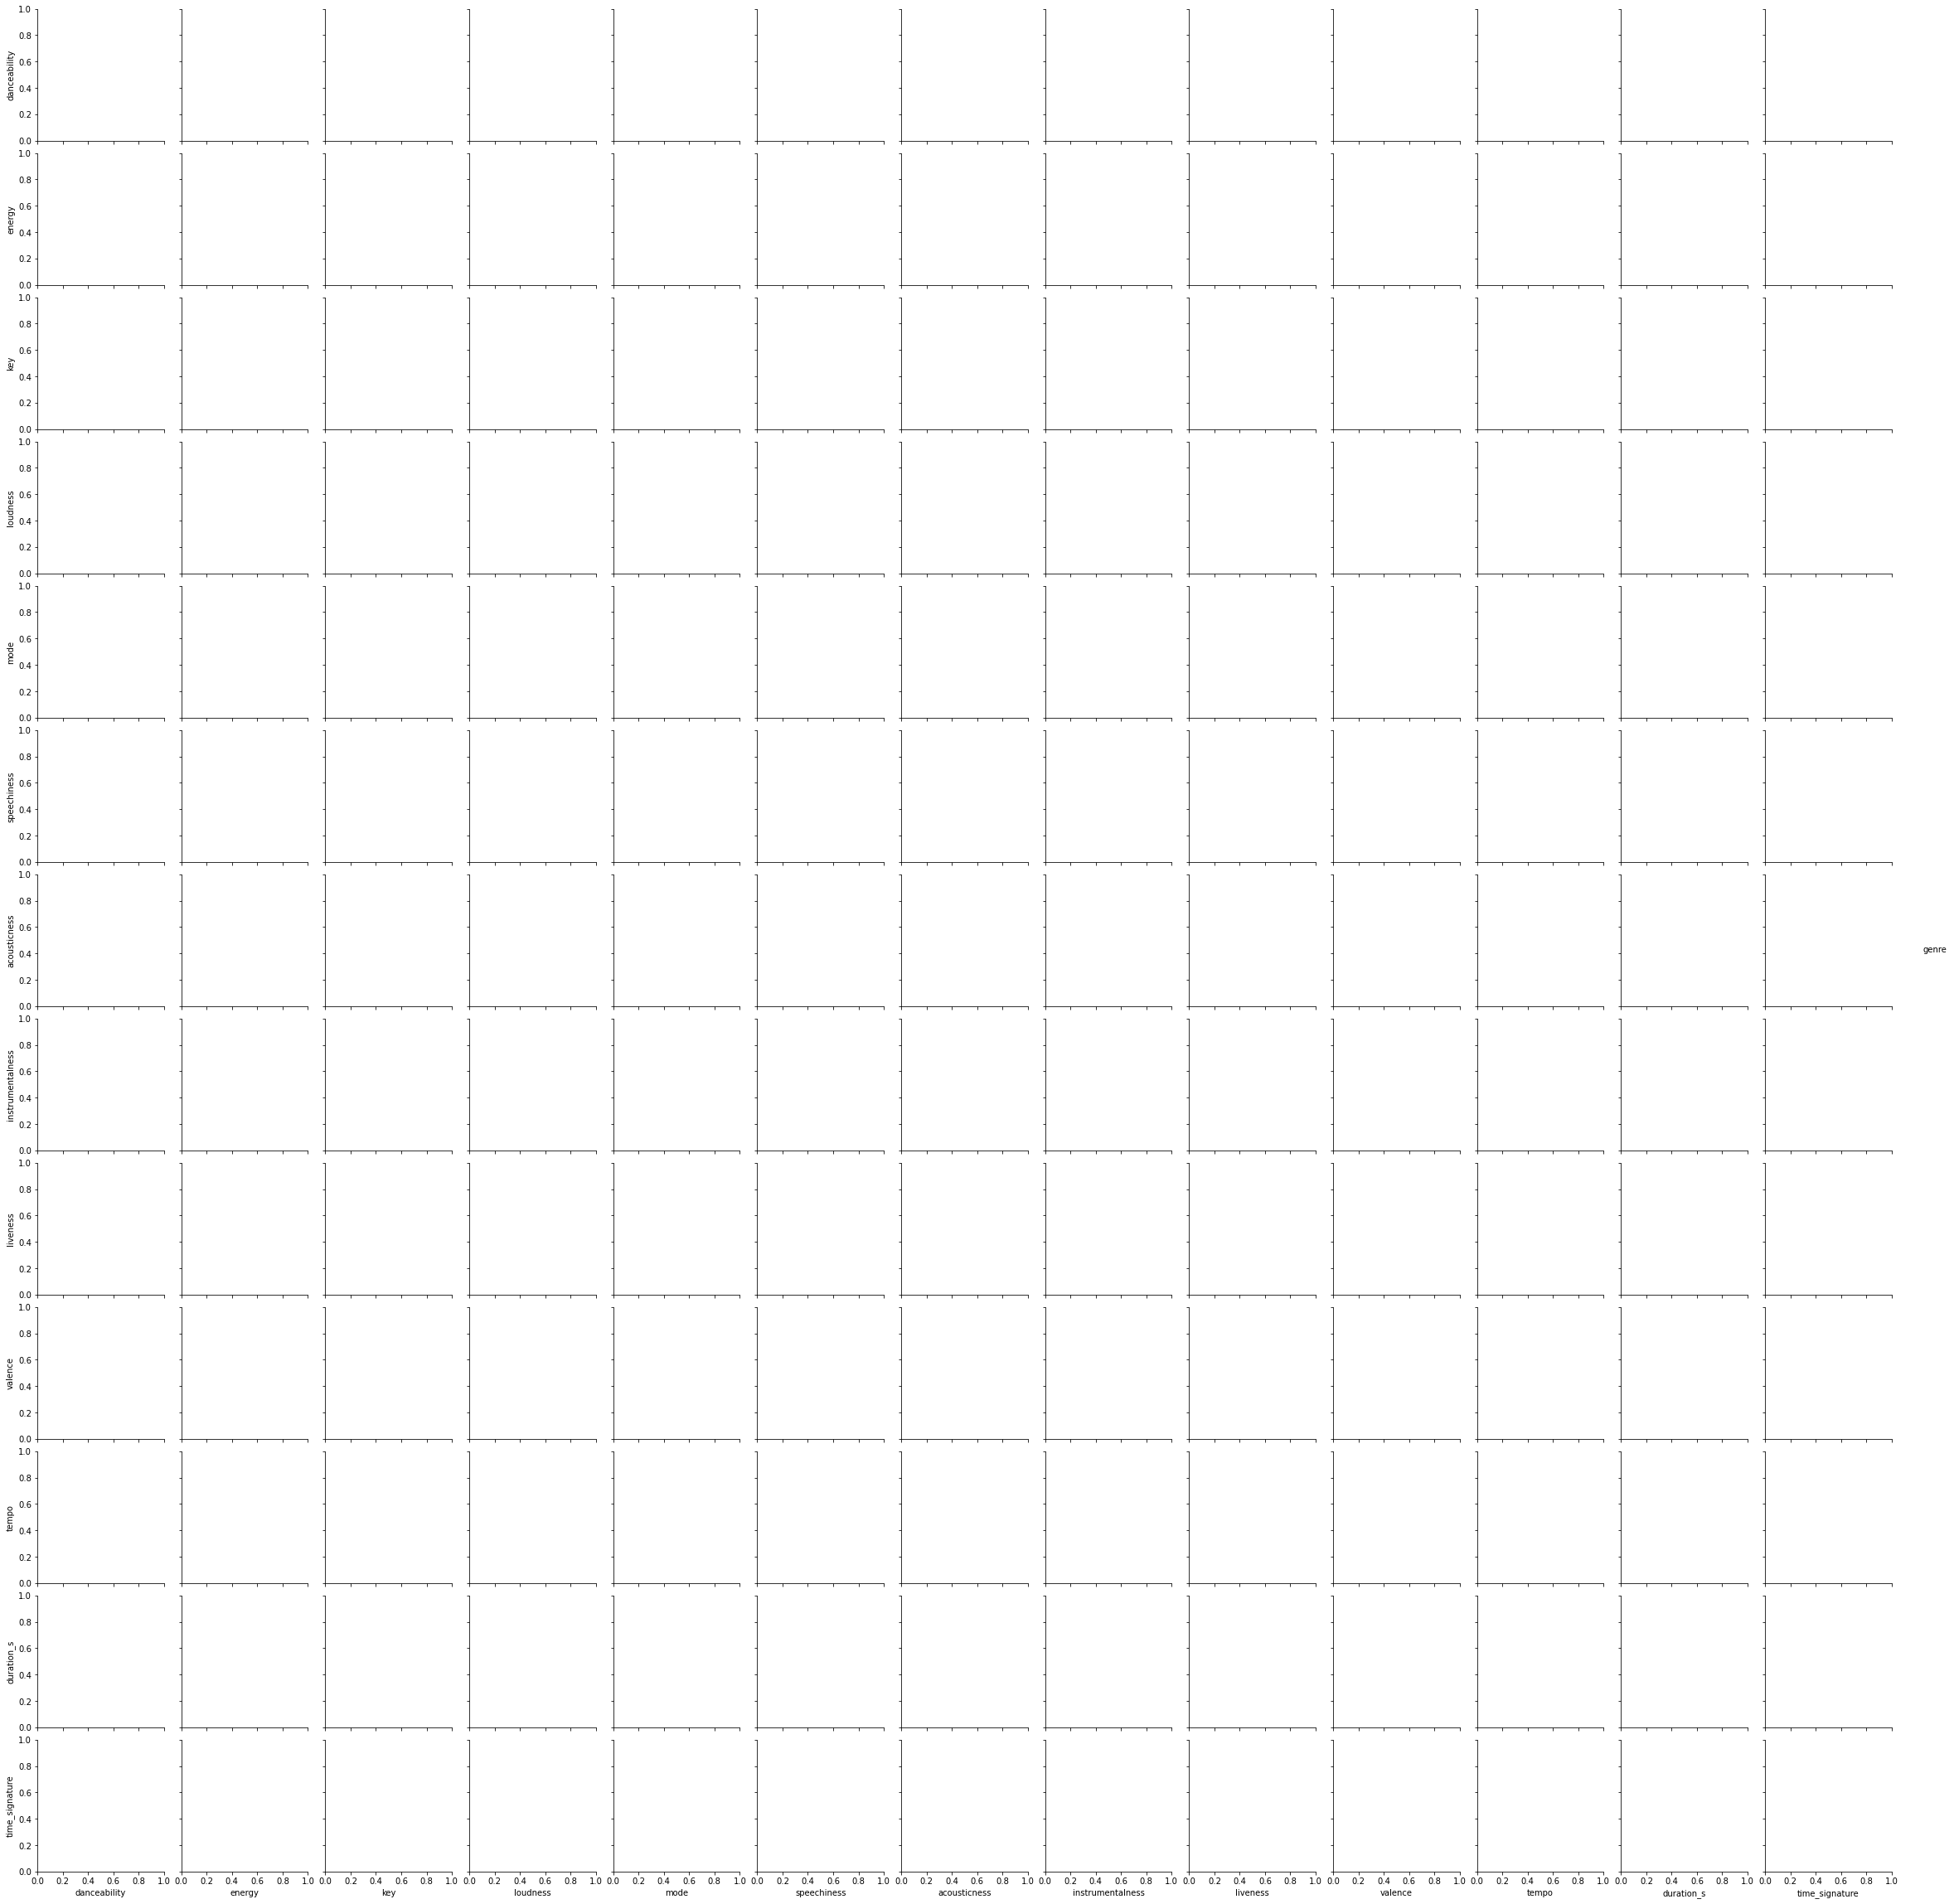

In [ ]:
sns.pairplot(data=train_combined, hue="genre")

## Model Selection

### Chi-square Test

<AxesSubplot:>

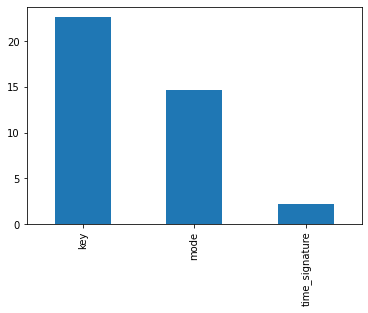

In [ ]:
chi2_statistics, chi2_p_scores = chi2(data["x_train"][data["categorical_features"]], data["y_train"])
chi2_scores = pd.Series(chi2_statistics, index=data["categorical_features"])
chi2_scores.sort_values(ascending=False).plot.bar()

ANOVA f Test

<AxesSubplot:>

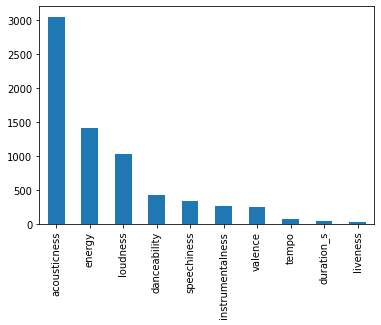

In [ ]:
anova_statistics, anova_p_scores = f_classif(data["x_train"][data["numeric_features"]], data["y_train"])
anova_scores = pd.Series(anova_statistics, index=data["numeric_features"])
anova_scores.sort_values(ascending=False).plot.bar()

### Mutual Information

<AxesSubplot:>

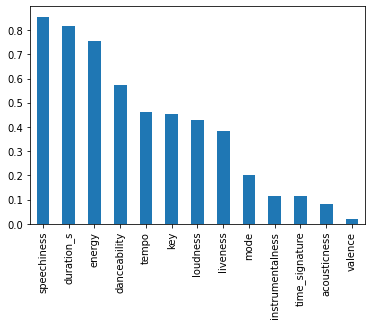

In [ ]:
discrete_features_indices = [list(data["x_train"].columns).index(x) for x in data["categorical_features"]]
mutual_statistics = mutual_info_classif(data["x_train"], data["y_train"], discrete_features=discrete_features_indices)
mutual_scores = pd.Series(mutual_statistics, index=data["features"])
mutual_scores.sort_values(ascending=False).plot.bar()

<AxesSubplot:>

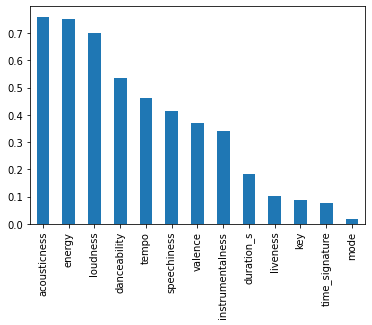

In [ ]:
discrete_features_indices = [list(x_test.columns).index(x) for x in categorical_features]
mutual_statistics = mutual_info_classif(x_train, y_train, discrete_features=discrete_features_indices)
mutual_scores = pd.Series(mutual_statistics, index=x_train.columns)
mutual_scores.sort_values(ascending=False).plot.bar()

### Tree-based feature importances

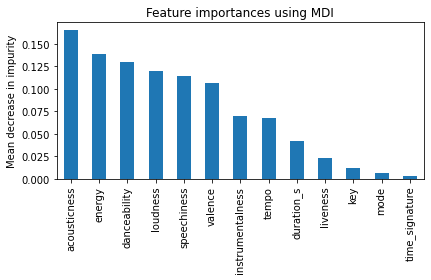

In [ ]:
clf = RandomForestClassifier(n_estimators=1000)
clf = clf.fit(x_train, y_train)

forest_importances = pd.Series(clf.feature_importances_, index=x_train.columns)
fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Nested Cross Validation

In [4]:

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import json


estimators = {}


estimators['knn'] = {
    'estimator': KNeighborsClassifier(),
    'paramGrid': {
            'n_neighbors' : [x for x in range(3, 30) if x % len(set(data["y_train"])) != 0],
            'weights' : ['uniform', 'distance'],
            'metric' : ['euclidean', 'manhattan']
            }
}

estimators['randomForest'] = {
    'estimator': RandomForestClassifier(),
    'paramGrid': {
            'bootstrap': [True],
            'max_depth': [10, 20, 30, 40],
            'max_features': [5, 13],
            'min_samples_leaf': [3, 4, 5, 8],
            'min_samples_split': [8, 12, 16],
            'n_estimators': [1000],#[500, 1000, 3000, 5000]
            
           } 
}

'''estimators['svc'] = {
    'estimator': SVC(probability=True),
    'paramGrid': [
            {"kernel": ["rbf"], "gamma": np.float_power(3, range(-8,-2)), "C": np.float_power(3, range(0,8))},
            {"kernel": ["linear"], "C": np.float_power(3, range(0,8))},
           ]
}'''

results = dict()
seed = 12345

for estimatorKey, estimatorValue in estimators.items():
    results[estimatorKey] = []
    
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    for train_index, test_index in outer_cv.split(X=data["x_train"], y=data["y_train"]):
        X_train, X_test = data["x_train"].iloc[train_index,:], data["x_train"].iloc[test_index,:]
        y_train, y_test = data["y_train"].iloc[train_index], data["y_train"].iloc[test_index]

        grid_search = GridSearchCV(
            estimator = estimatorValue['estimator'], 
            param_grid = estimatorValue['paramGrid'], 
            cv = inner_cv, 
            n_jobs = -1, 
            verbose = 1
        )

        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)

        res = {}
        res["acc_score"] = acc_score
        res["best_params"] = json.dumps(grid_search.best_params_)
        res["best_estimator"] = grid_search.best_estimator_

        print(type(grid_search.best_estimator_))
        
        results[estimatorKey].append(res)

    



NameError: name 'KNeighborsClassifier' is not defined

In [119]:
results

{'knn': [{'acc_score': 0.6567164179104478,
   'best_params': '{"metric": "manhattan", "n_neighbors": 3, "weights": "distance"}',
   'best_estimator': KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')},
  {'acc_score': 0.6467661691542289,
   'best_params': '{"metric": "manhattan", "n_neighbors": 8, "weights": "distance"}',
   'best_estimator': KNeighborsClassifier(metric='manhattan', n_neighbors=8, weights='distance')},
  {'acc_score': 0.685,
   'best_params': '{"metric": "manhattan", "n_neighbors": 19, "weights": "distance"}',
   'best_estimator': KNeighborsClassifier(metric='manhattan', n_neighbors=19, weights='distance')},
  {'acc_score': 0.695,
   'best_params': '{"metric": "manhattan", "n_neighbors": 19, "weights": "distance"}',
   'best_estimator': KNeighborsClassifier(metric='manhattan', n_neighbors=19, weights='distance')},
  {'acc_score': 0.59,
   'best_params': '{"metric": "manhattan", "n_neighbors": 9, "weights": "distance"}',
   'best_estimator': KN

In [41]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.svm import SVC

svc = SVC(C=10)

sfs1 = SFS(svc, 
           k_features=13, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(data["x_train"], data["y_train"])





[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.9s finished

[2022-01-25 13:53:49] Features: 1/13 -- score: 0.5878243512974052[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.5s finished

[2022-01-25 13:53:51] Features: 2/13 -- score: 0.7015968063872255[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.0s finished

[2022-01-25 13:53:52] Features: 3/13 -- score: 0.8033932135728543[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [47]:
sfs1.subsets_

#import pandas as pd
#print(pd.DataFrame.from_dict(sfs1.get_metric_dict()).T)

{1: {'feature_idx': (1,),
  'cv_scores': array([0.58782435]),
  'avg_score': 0.5878243512974052,
  'feature_names': ('energy',)},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([0.70159681]),
  'avg_score': 0.7015968063872255,
  'feature_names': ('danceability', 'energy')},
 3: {'feature_idx': (0, 1, 9),
  'cv_scores': array([0.80339321]),
  'avg_score': 0.8033932135728543,
  'feature_names': ('danceability', 'energy', 'valence')},
 4: {'feature_idx': (0, 1, 7, 9),
  'cv_scores': array([0.84730539]),
  'avg_score': 0.8473053892215568,
  'feature_names': ('danceability', 'energy', 'instrumentalness', 'valence')},
 5: {'feature_idx': (0, 1, 5, 7, 9),
  'cv_scores': array([0.88323353]),
  'avg_score': 0.8832335329341318,
  'feature_names': ('danceability',
   'energy',
   'speechiness',
   'instrumentalness',
   'valence')},
 6: {'feature_idx': (0, 1, 5, 6, 7, 9),
  'cv_scores': array([0.89620758]),
  'avg_score': 0.8962075848303394,
  'feature_names': ('danceability',
   'energy',
   '